In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider
%matplotlib inline

32336


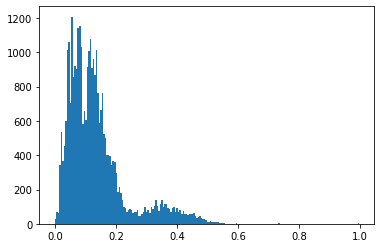

In [3]:
%matplotlib inline
galaxies_raw=pd.read_csv('DR15_galaxies.csv',error_bad_lines=False)
galaxies_raw=galaxies_raw.dropna(axis=0)
print(len(galaxies_raw))
plt.hist(galaxies_raw['redshift'],bins=200);

In [4]:
""" 
It is assumed that the data is withen the specified range
Yet, the range is asked from the user just to confirm
"""
from astropy.cosmology import Planck15 as cosmo
# start_z=float(input("Input the first values of redshift to use: "))
# end_z=float(input("Input the last value of redshift to use: "))
# galaxies_range=galaxies_raw[galaxies_raw['redshift'].between(start_z,end_z,inclusive=True)]
# galaxies_range=galaxies_raw.sample(500)
galaxies_range=galaxies_raw[:500] 
#choses galaxies that are furthest away from us between red 0.45 to end

print(f'Galaxies Range Length: {len(galaxies_range)}')
print(min(galaxies_range.redshift),max(galaxies_range.redshift))
galaxies_range['dist']=cosmo.comoving_distance(galaxies_range['redshift'])

Galaxies Range Length: 500
0.45037 0.9973055000000001


/home/pankaj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


500


/home/pankaj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


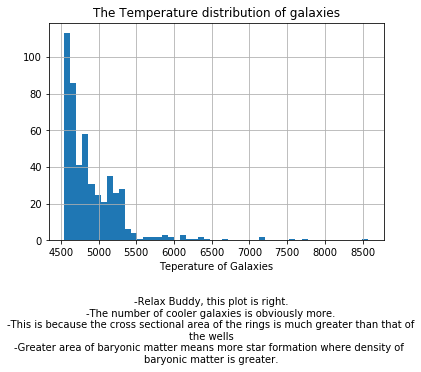

In [40]:
def find_temperatures():
    global galaxies_range
    
    magnitudes = 30 - galaxies_range.loc[:,'u':'z']
    redshifts=galaxies_range.loc[:,'redshift']

    bands = {"u": 3450, "g": 4760, "r": 6280, "i": 7690, "z": 9250}

    x = list(bands.values())
    
    temperatures=np.zeros(len(magnitudes))
    
    for i in range(len(magnitudes)):
        y = list(magnitudes.iloc[i,:])
        redshift=redshifts[i]        
        
        
        z = np.polyfit(x, y, 2)
        f = np.poly1d(z)

        # Scipy's interpolate.interp1d function is not used because it tends
        # to overfiit the data thereby producing incorrect temperature output
        
        # calculate new x's and y's
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)

        index = np.where(y_new == np.max(y_new))
        lambda_max=np.float(x_new[index])
        
        lambda_max=lambda_max/(1+redshift)
        
        T=2.898*10**-3/(lambda_max*10**-10)
        
        temperatures[i]=T
    
    print(len(temperatures))
    return temperatures

galaxies_range['temperature']=find_temperatures()
# sns.distplot(galaxies_range['temperature'],bins=50)
plt.hist(galaxies_range['temperature'],bins=50)
plt.xlabel('Teperature of Galaxies')
# plt.ylabel('Probabililty')
plt.title('The Temperature distribution of galaxies')
plt.grid()
pass

In [6]:
"""
This part of the code calculates the angular_seperation
"""
import numpy as np
def angular_dist(ra1, dec1, ra2, dec2,d1,d2):
    a = np.sin(np.abs(dec1 - dec2) / 2) ** 2
    b = np.cos(dec1) * np.cos(dec2) * (np.sin(np.abs(ra1 - ra2) / 2)) ** 2
    d = 2 * np.arcsin(np.sqrt(a + b))
    sep=np.sqrt(d1**2 + d2**2 - (2*d1*d2*np.cos(d)))
    return sep


length=len(galaxies_range)*(len(galaxies_range))//2
print(length)
angular_seperation = np.zeros((length-1,4))
# indicies=galaxies_range.index
"""
-1:Spiral-Spiral
0:Spiral-Elliptical
1:Elliptical-Elliptical
"""
k=0
for i in range(len(galaxies_range)-1):
    line1=galaxies_range.iloc[i,:]
    for j in range(i+1,len(galaxies_range)):
        line2=galaxies_range.iloc[j,:]

        angular_seperation[k,0]=np.int(line1['objid'])
        angular_seperation[k,1]=np.int(line2['objid'])
        angular_seperation[k,2]= angular_dist(line1['ra'], 
                        line1['dec'], 
                        line2['ra'], 
                        line2['dec'],
                        line1['redshift'],
                        line2['redshift'])
#     if line1['spiral']==1 and line2['spiral']==1:
#         spam=-1
#     elif line2['elliptical']==1 and line2['elliptical']==1:
#         spam=1
#     else:
#         spam=0

        spam=np.abs(line1['temperature']-line2['temperature'])
        angular_seperation[k,3]=spam
        k+=1
print(k)
angular_seperation=angular_seperation[:k]
difference=pd.DataFrame(angular_seperation, columns=['objid1','objid2','seperation','temperature'])
print("Done Execution")

125000
124750
Done Execution


115608


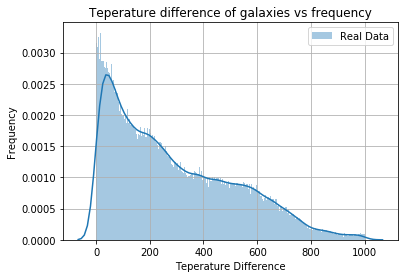

In [41]:
n=250
# ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
# ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)
# spam1,b1,spam=ax.hist(difference.temperature,bins=n, alpha=0.4, label='Real Data');
# spam2,spam,spam=ax.hist(simulated_difference.temperature, bins=b1, alpha=0.4, label='Simulated Data');

temperatuer_dffference=difference.temperature[(difference.temperature>0)&(difference.temperature<1000)]
print(len(temperatuer_dffference))
_=sns.distplot(temperatuer_dffference,bins=n, label='Real Data');
plt.grid();
plt.legend();
plt.xlabel('Teperature Difference');
plt.ylabel('Frequency');
plt.title('Teperature difference of galaxies vs frequency');
# plt.savefig("Temperature diff.svg")
data = _.get_lines()[0].get_data()
x_data = data[0]#[np.sum(data[0] < 0) :]
y_data = data[1]#[np.sum(data[0] < 0) :]
df=pd.DataFrame({'Xdata':x_data,'Ydata':y_data})
df.Ydata=df.Ydata/np.max(df.Ydata)
df.to_csv('RealValues.csv', index=False)
# plt.plot(df.Xdata,df.Ydata)

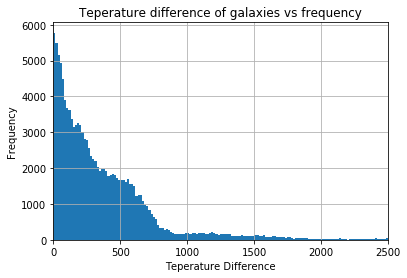

In [21]:
{
    "tags": [
        "hide_input",
    ]
}
n=250
# sns.distplot(difference[difference['temperature']<600].temperature, kde=True, bins=n);
# print(f"Optimal number of bins {sns.distributions._freedman_diaconis_bins(difference[difference['temperature']<600].temperature)}")
# print(f"Current number of bins {n}")
_=plt.hist(difference.temperature,bins=n);
      
# heights=_[0]
# widths=np.average(np.hstack([_[1][:-1][None].T, _[1][1:][None].T]),axis=1)


# plt.hlines(np.average(heights),xmin=min(_[1]), xmax=max(_[1]))

# widths,heights=widths[heights>np.average(heights)],heights[heights>np.average(heights)]

# value=np.mean(np.diff(np.hstack([_[1][:-1][None].T, _[1][1:][None].T]),axis=0))
# idx=np.insert(np.diff(np.hstack([widths[:-1][None].T, widths[1:][None].T]),axis=1)>value,0,True)
# # print(idx)

# widths=widths[idx]
# heights=heights[idx]

# # plt.scatter(widths,heights,marker='x',c='r')

# # x_smooth = np.linspace(min(widths), max(widths), 200)
# z = np.polyfit(widths, heights, 5)
# f = np.poly1d(z)

# # calculate new x's and y's
# x_new = np.linspace(0, 500, 50)
# y_new = f(x_new)

# plt.plot(x_new,y_new)
plt.grid()
plt.xlabel('Teperature Difference')
plt.ylabel('Frequency')
plt.title('Teperature difference of galaxies vs frequency')
plt.xlim((0,2500))
pass
# plt.savefig('temp_difference_freq.svg', bbox_inches='tight')

/home/idies/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


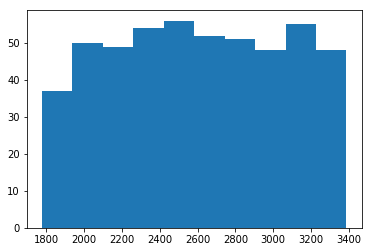

In [362]:
from astropy.cosmology import Planck15 as cosmo
simulated_galaxies=pd.DataFrame([],columns=['ra','dec','redshift','temperature'])
simulated_galaxies.temperature=np.random.normal(np.mean(galaxies_range.temperature)
                                                ,np.std(galaxies_range.temperature)
                                                ,len(galaxies_range.temperature))
simulated_galaxies.ra=np.random.uniform(np.min(galaxies_range.ra),
                                       np.max(galaxies_range.ra),
                                       len(galaxies_range.ra))
simulated_galaxies.dec=np.random.uniform(np.min(galaxies_range.dec),
                                       np.max(galaxies_range.dec),
                                       len(galaxies_range.dec))
simulated_galaxies.redshift=np.random.uniform(np.min(galaxies_range.redshift),
                                       np.max(galaxies_range.redshift),
                                       len(galaxies_range.redshift))

simulated_galaxies.dist=cosmo.comoving_distance(simulated_galaxies.redshift)
plt.hist(simulated_galaxies.dist.value);

In [363]:
"""
This part of the code calculates the angular_seperation
"""
import numpy as np
def angular_dist(ra1, dec1, ra2, dec2,d1,d2):
    a = np.sin(np.abs(dec1 - dec2) / 2) ** 2
    b = np.cos(dec1) * np.cos(dec2) * (np.sin(np.abs(ra1 - ra2) / 2)) ** 2
    d = 2 * np.arcsin(np.sqrt(a + b))
    sep=np.sqrt(d1**2 + d2**2 - (2*d1*d2*np.cos(d)))
    return sep


length=len(simulated_galaxies)*(len(simulated_galaxies))//2
print(length)
sim_angular_seperation = np.zeros((length-1,2))

k=0
for i in range(len(simulated_galaxies)-1):
    line1=simulated_galaxies.iloc[i,:]
    for j in range(i+1,len(simulated_galaxies)):
        line2=simulated_galaxies.iloc[j,:]

        sim_angular_seperation[k,0]= angular_dist(line1['ra'], 
                        line1['dec'], 
                        line2['ra'], 
                        line2['dec'],
                        line1['redshift'],
                        line2['redshift'])
        spam=np.abs(line1['temperature']-line2['temperature'])
        sim_angular_seperation[k,1]=spam
        k+=1
print(k)
sim_angular_seperation=sim_angular_seperation[:k]
simulated_difference=pd.DataFrame(sim_angular_seperation, columns=['seperation','temperature'])
print("Done Execution")

125000
124750
Done Execution
